# Galaxy SEDs using galaxpy
Jonas Chaves-Montero 2019

In this notebook I am going to explain how to generate SEDs for galaxies using GALAXEV + other programs

### New version (March 2019)
It includes an option for changing the properties of galaxy emission lines

## Software required

Everything in a tarball:

#### GALAXEV (Bruzual and Charlot 2003)

The last version can be found in:
http://www.bruzual.org/bc03/Updated_version_2016/

This code is widely tested, e.g. Baldwin et al. 2018

#### Emission line ratios (Gutkin et al. 2016)

#### Dust extinction

Embbeded in GALAXEV or a posteriori

#### IGM extinction

From ELDAR (personal code)

#### Filter creation

From ELDAR (personal code)

#### Galaxy SFHs

GP emulator

The python vs is Python 3.x. Packages required:

- Native

os, subprocess, glob, sys, math, numpy, scipy, natsort, astropy

- Non native

shutil, extinction

# Usage

Import packages

In [7]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import glob

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=67.26, 
                      Om0=0.314, 
                      Ob0=0.049)

In [9]:
path_program = os.path.dirname( os.getcwd() ) + '/'
print(path_program)
sys.path.append(path_program)

/home/jchavesmontero/Proyectos/projects/gen_templates/program/


In [10]:
# Module to create filters (ELDAR)
from p_galaxpy.create_filters import create_top_hat_filters

# main program. It is a class with many options
from p_galaxpy.galaxpy import galaxy_sed

## Create new filters

Required keys in input dictionary

name_survey: survey name for this set of filters

lambda_res: spectral resolution $R=\lambda/\Delta\lambda$

lambda_in: starting wavelength of the first filter

lambda_out: final wavelength of the last filter

num_first: number associated to the first filter created here.
  It is useful if you want to create filters with different 
  resolutions
  
 The name of the output files is name_survey + '-band_' + n + '.filt', 
 where n is the number of the nth filter

In [11]:
Sres = 40
params = {'name_survey': 'test_R_'+str(Sres), 
          'lambda_res': Sres, 
          'lambda_in': 3000, 
          'lambda_out': 9000, 
          'num_first': 1}
create_top_hat_filters(params)

44 bands were created


## Get galaxy SEDs

We are going to start defining some input parameters. They are defined below. 

The parameters to explore are:

metal, tau_V, eta_V, Mpeak, and gal_type

In [17]:
# Unique name of this run
seed = 'test0'

# metal: free discrete parameter (metallicity). Options supported:
# 0.0001, 0.0004, 0.004, 0.008, 0.02, 0.05, 0.1 [Padova1994].
# 0.0004, 0.001, 0.004, 0.008, 0.019, 0.03 [Padova2000]
# Padova1994 is the fiducial option
# metal = np.array([0.0001, 0.0004, 0.004, 0.008, 0.02, 0.05, 0.1])
metal = 0.0004

# IMF: free discrete parameter. Options supported:
# salpeter 'salp', chabrier 'chab', and kroupa 'kroup'
IMF = 'chab'

# properties of the galaxy emission lines
# flag Y or N (include lines or not)
# metal_line: discrete free parameter. Values supported:
# 0.0001, 0.0002, 0.0005,0.001, 0.002, 0.004, 0.006, 0.008,
# 0.010, 0.014, 0.017, 0.020, 0.030, 0.040
# log_io: discrete free parameter. Values supported:
# -1. , -1.5, -2. , -2.5, -3. , -3.5, -4. 
em_lines = {'flag': 'Y',
            'metal_line': 0.001, 
            'log_io':-3.5}

# gal_typeL free discrete parameter. Options supported:
# sf (star-forming) or qs (quenched)
gal_type = 'qs'

# mpeak: free continuous parameter. 9-14.
mpeak = 13

# Extinction model
# I recommend to always use flag == galaxev
# tau_V: free continuous parameter. 0-6
# etau_V: free continuous parameter. 0-4
# no all combinations are equally probable. I find from observations that
# in general 2/tau_V > etau_V. Take this into account before generating new samples.
dust = {'flag': 'galaxev',
        'tau_V':'0.5',
        'etau_V':'0.2'}


flag_mag = 'Y' # compute magntidues in (see next parameters)
survey_filt = 'all_lsst' # LSST bands (ugrizY)
# survey_filt = 'SDSS' # SDSS bands (ugriz)
flag_IGM_ext = 'Y' # apply intergalactic extinction (only important at high redshift)

params = {'metallicity': metal,
        'IMF': IMF,
        'mpeak': mpeak,
        'gal_type': gal_type,
        'dust': dust,
        'survey_filt': survey_filt,
        'flag_mag': flag_mag,
        'em_lines': em_lines,
        'flag_IGM_ext': flag_IGM_ext,
        'cosmo': cosmo,
        'seed': seed}


xx = galaxy_sed(params)

This program has called internally to GALAXEV. 

GALAXEV has computed the evolution of the stellar emission as a function of cosmic age.

In what follows we retrive this emission and:
    
add emission lines

apply IGM extinction

We will get the SEDs at the redshifts defined below. It is important to note that if we want to get SEDs at different redshifts we do not have to run GALAXEV again. It saves time.

In [18]:
# Maximum 50 ages 
# (internal problem of galaxev for larger number)
# run several times if you need greater redshift precision

nn = 10
zmin = 0
zmax = 1
zz = np.arange(nn)/(nn-1)*(zmax-zmin) + zmin

xx.run_galaxev_gpl(zz)

We get the results for z>0 in

In the following figure I show the observed flux for this galaxy at different redshifts

<IPython.core.display.Javascript object>


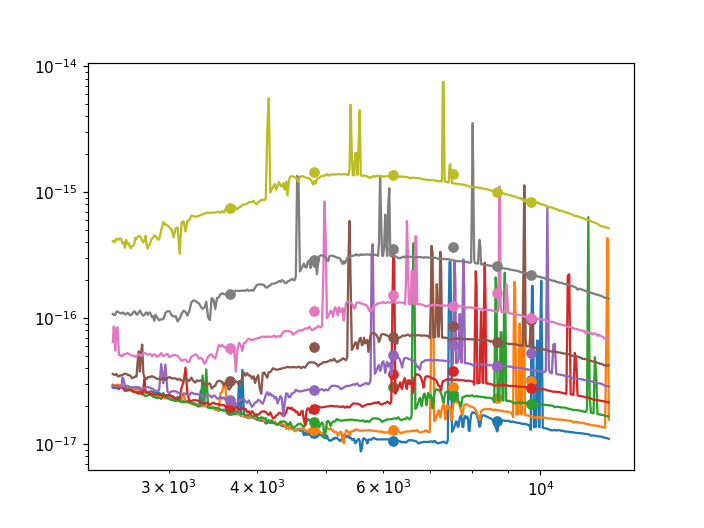

In [19]:
for ii in range(0, nn):
    if(xx.zz[ii] > 0):
#         print('Cosmic age', xx.age[ii], 'Redshift', xx.zz[ii])
        plt.loglog(xx.wav, xx.flux_obs[:, ii], 'C'+str(ii))
        plt.plot(xx.filter_pivot, xx.obs_flux[:, ii], 'C'+str(ii)+'o')

In [46]:
plt.close()

and in the next one the observed magnitudes of this galaxy at different redshifts.

The magnitudes are in the filters that we created. You can use LSST filters too. You can also manually introduce a new set of filters 

Cosmic age 5.866 Redshift 1.0


<IPython.core.display.Javascript object>


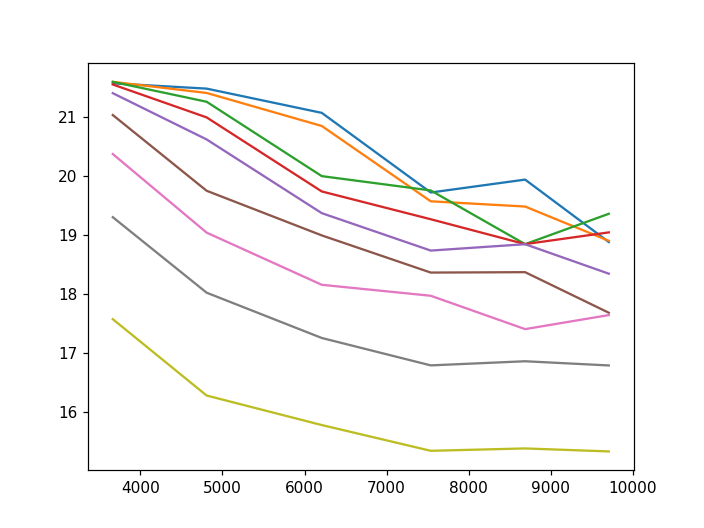

Cosmic age 6.347 Redshift 0.8888888888888888
Cosmic age 6.891 Redshift 0.7777777777777778
Cosmic age 7.512 Redshift 0.6666666666666666
Cosmic age 8.221 Redshift 0.5555555555555556
Cosmic age 9.037 Redshift 0.4444444444444444
Cosmic age 9.979 Redshift 0.3333333333333333
Cosmic age 11.072 Redshift 0.2222222222222222
Cosmic age 12.346 Redshift 0.1111111111111111


In [20]:
for ii in range(0, nn):
    if(xx.zz[ii] > 0):
        print('Cosmic age', xx.age[ii], 'Redshift', xx.zz[ii])
        plt.plot(xx.filter_pivot, xx.obs_mag[:, ii])